In [10]:
import numpy as np

def compute_mse(symbols_tx, symbols_rx):
    diff = symbols_tx - symbols_rx
    mse = np.mean(np.abs(diff) ** 2)
    return mse

In [11]:
import numpy as np

def compute_ber(bits_tx, bits_rx):
    errors = (bits_tx != bits_rx)
    ber = np.mean(errors)
    return ber

In [12]:
import numpy as np

def ofdm_demodulate(rx_slot):
    N_FFT = 4096
    CP_LENGTHS = [320] + [288]*6 + [320] + [288]*6
    TOTAL_SAMPLES = 61440
    N_SC = 3276
    
    if len(rx_slot) != TOTAL_SAMPLES:
        raise ValueError('rx_slot length mismatch')
    
    grid_rx = np.zeros((N_SC, 14), dtype=complex)
    idx = 0
    for s in range(14):
        idx += CP_LENGTHS[s]
        sym_td = rx_slot[idx:idx+N_FFT]
        idx += N_FFT
        bins = np.fft.fft(sym_td) / N_FFT
        bins_shifted = np.fft.fftshift(bins)
        half = N_SC // 2
        center = N_FFT // 2
        start = center - half
        grid_rx[:, s] = bins_shifted[start:start+N_SC]
    
    return grid_rx

In [13]:
import numpy as np

def qpsk(bits):
    b = bits.astype(float)
    I = 1 - 2 * b[:, :, 0]
    Q = 1 - 2 * b[:, :, 1]
    symbols = (I + 1j * Q) / np.sqrt(2)
    return symbols

def qam16_gray(bits):
    b = bits.astype(float)
    I = (1 - 2*b[:, :, 0]) * (1 + 2*b[:, :, 2])
    Q = (1 - 2*b[:, :, 1]) * (1 + 2*b[:, :, 3])
    symbols = (I + 1j * Q) / np.sqrt(10)
    return symbols

def qam64_gray(bits):
    b = bits.astype(float)
    I = (1 - 2*b[:, :, 0]) * (4 - (1 - 2*b[:, :, 2]) * (2 - (1 - 2*b[:, :, 4])))
    Q = (1 - 2*b[:, :, 1]) * (4 - (1 - 2*b[:, :, 3]) * (2 - (1 - 2*b[:, :, 5])))
    symbols = (I + 1j * Q) / np.sqrt(42)
    return symbols

In [14]:
import numpy as np

def qpsk_demod(symbols):
    I = np.real(symbols)
    Q = np.imag(symbols)
    b0 = (I < 0).astype(np.uint8)
    b1 = (Q < 0).astype(np.uint8)
    return np.stack((b0, b1), axis=-1)

def qam16_gray_demod(symbols):
    scale = np.sqrt(10)
    I = np.real(symbols) * scale
    Q = np.imag(symbols) * scale
    b0 = (I < 0).astype(np.uint8)
    b1 = (Q < 0).astype(np.uint8)
    b2 = (np.abs(I) > 2).astype(np.uint8)
    b3 = (np.abs(Q) > 2).astype(np.uint8)
    bits = np.stack((b0, b1, b2, b3), axis=-1)
    return bits

def qam64_gray_demod(symbols):
    scale = np.sqrt(42)
    I = np.real(symbols) * scale
    Q = np.imag(symbols) * scale
    absI = np.abs(I)
    absQ = np.abs(Q)
    
    b0 = (I < 0).astype(np.uint8)
    b1 = (Q < 0).astype(np.uint8)
    b2 = (absI > 3).astype(np.uint8)
    b3 = (absQ > 3).astype(np.uint8)
    
    b4 = np.where((b2 == 0) & (absI == 1) | (b2 == 1) & (absI == 7), 1, 0).astype(np.uint8)
    b5 = np.where((b3 == 0) & (absQ == 1) | (b3 == 1) & (absQ == 7), 1, 0).astype(np.uint8)
    
    return np.stack((b0, b1, b2, b3, b4, b5), axis=-1)

In [15]:
import numpy as np

class TDLB100:
    POW_DB = np.array([0.0, -2.2, -0.6, -0.6, -0.3, -1.2, -5.9, -2.2, -0.8, -6.3, -7.5, -7.1])
    DEL_NS = np.array([0.0, 10.0, 20.0, 30.0, 35.0, 45.0, 55.0, 120.0, 170.0, 245.0, 330.0, 480.0])
    
    def __init__(self, fs, fd=25.0, seed=None, M=16):
        self.fs = fs
        self.fd = fd
        self.rng = np.random.RandomState(seed)
        self.p_lin = 10**(self.POW_DB/10)
        self.del_samp = np.round(self.DEL_NS * 1e-9 * fs).astype(int)
        self.ntaps = len(self.p_lin)
        self.tau_max = np.max(self.del_samp)
        
        k = np.arange(1, M+1)
        alpha = np.pi * (k - 0.5) / M
        omega = 2 * np.pi * fd * np.cos(alpha)
        phi = 2 * np.pi * self.rng.rand(self.ntaps, M)
        scale2 = 2.0 / M
        self.faders = (omega, phi, scale2)
    
    def cir(self, num, start=0):
        omega, phi, scale2 = self.faders
        t = (start + np.arange(num)) / self.fs
        i = np.zeros((self.ntaps, num))
        q = np.zeros((self.ntaps, num))
        
        for tap in range(self.ntaps):
            pha = np.outer(omega, t) + phi[tap, :, None]
            i[tap, :] = np.sqrt(scale2) * np.sum(np.cos(pha), axis=0)
            q[tap, :] = np.sqrt(scale2) * np.sum(np.sin(pha), axis=0)
        
        h = i + 1j * q
        h *= np.sqrt(self.p_lin)[:, None]
        return h
    
    def apply_channel(self, x):
        x = x.ravel()
        N = len(x)
        y = np.zeros(N + self.tau_max, dtype=complex)
        h = self.cir(N)
        
        for k in range(self.ntaps):
            d = self.del_samp[k]
            y[d:d+N] += h[k, :] * x
        
        y = y[:N]
        y /= np.sqrt(np.mean(np.abs(y)**2))
        y *= np.sqrt(np.mean(np.abs(x)**2))
        return y
    
    def get_noise(self, x, snr_db):
        N = len(x)
        snr_lin = 10**(snr_db/10)
        noise_var = np.mean(np.abs(x)**2) / snr_lin
        noise = np.sqrt(noise_var/2) * (self.rng.randn(N) + 1j * self.rng.randn(N))
        return noise

In [36]:
import numpy as np

def mmse_est_sparse(rx_grid, dmrs_tx, dmrs_col, delta_f, tau_rms):
    N_SC = rx_grid.shape[0]
    pilot_idx = np.arange(0, N_SC, 2)
    Y_pilot = rx_grid[pilot_idx, dmrs_col]
    X_pilot = dmrs_tx[pilot_idx]
    H_pilot = Y_pilot / X_pilot
    
    # Build correlation matrices
    n = np.arange(N_SC)
    k = n[:, None] - n[None, :]
    Rhh = 1 / (1 + 1j * 2 * np.pi * delta_f * tau_rms * k)
    
    Rhp = Rhh[:, pilot_idx]
    Rpp = Rhh[pilot_idx][:, pilot_idx]
    
    
    # MMSE estimation
    R_inv = np.linalg.inv(Rpp + 0.01 * np.eye(len(pilot_idx)))
    H_est = Rhp @ R_inv @ H_pilot

    noise_var = np.mean(np.abs(Y_pilot - H_est[pilot_idx] * X_pilot)**2)
    
    R_inv = np.linalg.inv(Rpp + noise_var * np.eye(len(pilot_idx)))
    H_est = Rhp @ R_inv @ H_pilot

    return H_est, noise_var

In [25]:
import numpy as np
from scipy.interpolate import interp1d

def ls_est_sparse(rx_grid, dmrs_tx, dmrs_col, method='linear'):
    N_SC = rx_grid.shape[0]
    pilot_idx = np.arange(0, N_SC, 2)
    Y_pilot = rx_grid[pilot_idx, dmrs_col]
    X_pilot = dmrs_tx[pilot_idx]
    H_pilot = Y_pilot / X_pilot
    
    H_est = np.zeros(N_SC, dtype=complex)
    
    if method == 'linear':
        x = np.arange(N_SC)
        interp_real = interp1d(pilot_idx, np.real(H_pilot), kind='linear', fill_value="extrapolate")
        interp_imag = interp1d(pilot_idx, np.imag(H_pilot), kind='linear', fill_value="extrapolate")
        H_est = interp_real(x) + 1j * interp_imag(x)
    elif method == 'spline':
        H_est[pilot_idx] = H_pilot
        H_est[1::2] = H_est[0::2]  # Copy even to odd
    
    return H_est, None

In [26]:
import numpy as np

def map_subcarriers(sym_freq, n_fft):
    k = len(sym_freq)
    half = k // 2
    vec_shift = np.zeros(n_fft, dtype=complex)
    center = n_fft // 2
    start = center - half
    vec_shift[start:start+k] = sym_freq
    return np.fft.ifftshift(vec_shift)

def ofdm_modulate(grid):
    N_FFT = 4096
    CP_LENGTHS = [320] + [288]*6 + [320] + [288]*6
    TOTAL_SAMPLES = 61440
    
    N_SC, N_SYM = grid.shape
    symbols_td = np.array([], dtype=complex)
    
    for s in range(N_SYM):
        vec = map_subcarriers(grid[:, s], N_FFT)
        time_sym = np.fft.ifft(vec)
        cp = time_sym[-CP_LENGTHS[s]:]
        symbols_td = np.concatenate((symbols_td, cp, time_sym))
    
    tx = N_FFT * symbols_td
    if len(tx) != TOTAL_SAMPLES:
        raise ValueError('Sample count mismatch')
    return tx

In [27]:
import numpy as np

def zf_eq(rx_grid, H_est, dmrs_col):
    n_sym = rx_grid.shape[1]
    data_cols = [i for i in range(n_sym) if i != dmrs_col]
    Y_data = rx_grid[:, data_cols]
    if H_est.ndim == 1:
        H_est = H_est[:, None]
    return Y_data / H_est

In [28]:
import numpy as np

def build_grid(symbols, dmrs_vec, dmrs_col):
    N_SC, N_SYM = symbols.shape
    grid = np.zeros((N_SC, N_SYM+1), dtype=complex)
    data_cols = [i for i in range(N_SYM+1) if i != dmrs_col]
    grid[:, data_cols] = symbols
    grid[:, dmrs_col] = dmrs_vec.ravel()
    return grid

In [29]:
import pandas as pd
import numpy as np
import re

def parse_complex(s):
    s = str(s).strip().replace('i', 'j')
    try:
        return complex(s)
    except:
        return 0.0

def load_dmrs(filename, num_subcarriers):
    df = pd.read_excel(filename, header=None)
    raw_data = df[0].values
    dmrs_data = np.array([parse_complex(x) for x in raw_data[:num_subcarriers]])
    return dmrs_data

In [30]:
import numpy as np

def mmse_eq(rx_grid, H_est, noise_var, dmrs_col):
    n_sym = rx_grid.shape[1]
    data_cols = [i for i in range(n_sym) if i != dmrs_col]
    Y_data = rx_grid[:, data_cols]
    if H_est.ndim == 1:
        H_est = H_est[:, None]
    W = np.conj(H_est) / (np.abs(H_est)**2 + noise_var)
    return W * Y_data


=== QPSK Simulation ===

=== 16QAM Simulation ===

=== 64QAM Simulation ===


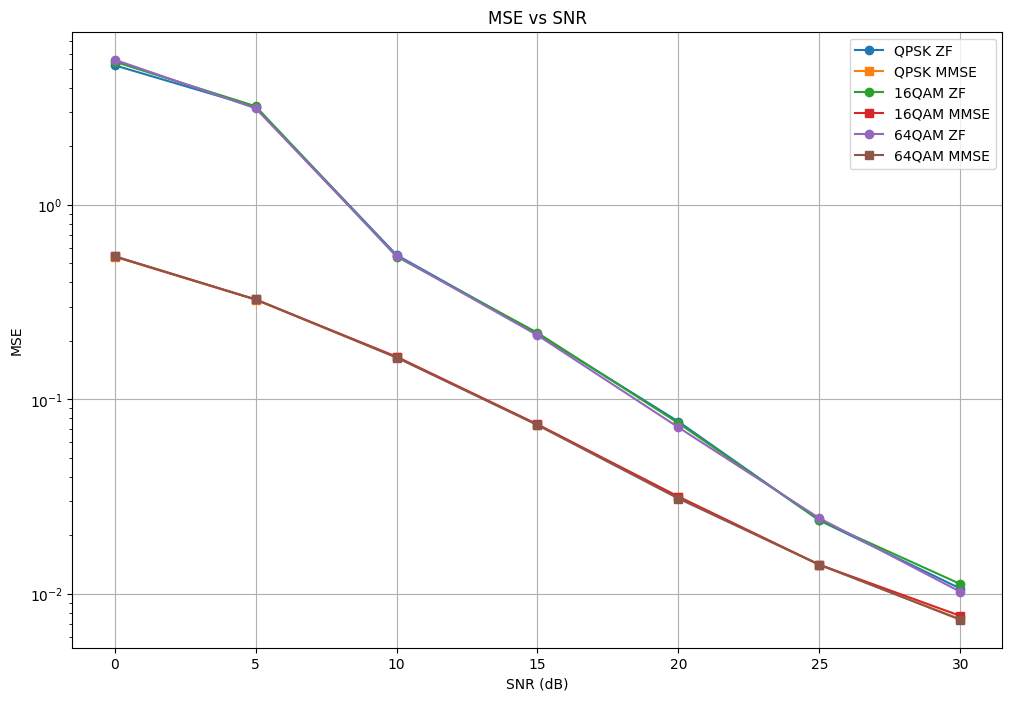

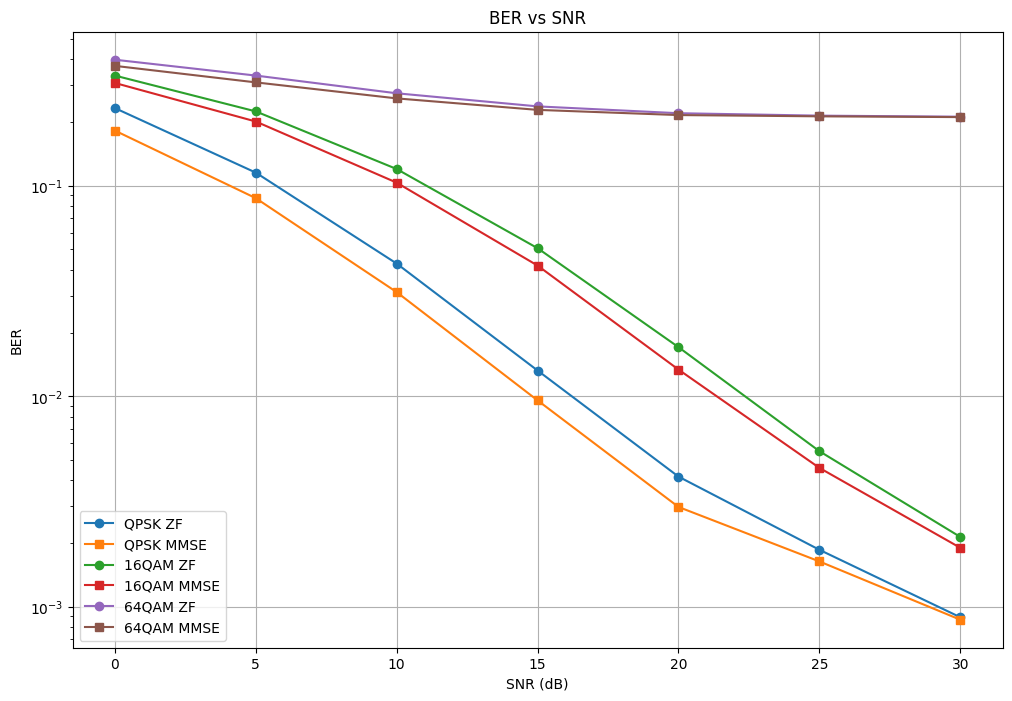


Results Summary:
SNR(dB)	Mod	ZF MSE		MMSE MSE	ZF BER		MMSE BER
0	QPSK	5.22e+00	5.41e-01	2.34e-01	1.83e-01
0	16QAM	5.45e+00	5.43e-01	3.34e-01	3.08e-01
0	64QAM	5.58e+00	5.44e-01	3.97e-01	3.72e-01
5	QPSK	3.19e+00	3.25e-01	1.16e-01	8.74e-02
5	16QAM	3.21e+00	3.26e-01	2.26e-01	2.02e-01
5	64QAM	3.14e+00	3.26e-01	3.34e-01	3.10e-01
10	QPSK	5.52e-01	1.64e-01	4.27e-02	3.13e-02
10	16QAM	5.42e-01	1.66e-01	1.20e-01	1.04e-01
10	64QAM	5.46e-01	1.64e-01	2.75e-01	2.60e-01
15	QPSK	2.17e-01	7.42e-02	1.33e-02	9.57e-03
15	16QAM	2.20e-01	7.43e-02	5.06e-02	4.18e-02
15	64QAM	2.14e-01	7.36e-02	2.39e-01	2.30e-01
20	QPSK	7.68e-02	3.13e-02	4.16e-03	2.98e-03
20	16QAM	7.54e-02	3.16e-02	1.71e-02	1.34e-02
20	64QAM	7.17e-02	3.09e-02	2.21e-01	2.17e-01
25	QPSK	2.38e-02	1.41e-02	1.87e-03	1.64e-03
25	16QAM	2.39e-02	1.41e-02	5.49e-03	4.57e-03
25	64QAM	2.45e-02	1.41e-02	2.16e-01	2.14e-01
30	QPSK	1.06e-02	7.40e-03	8.92e-04	8.69e-04
30	16QAM	1.12e-02	7.69e-03	2.15e-03	1.91e-03
30	64QAM	1.02e-02	7.35e-03	2.13e-01	2.12e-01


In [37]:
# Jupyter Notebook implementation
import numpy as np
import matplotlib.pyplot as plt
# from compute_mse import compute_mse
# from ofdm_demodulate import ofdm_demodulate
# from qpsk import qpsk
# from compute_ber import compute_ber
# from qam16_gray_demod import qam16_gray_demod
# from ls_est_sparse import ls_est_sparse
# from TDLB100 import TDLB100
# from ofdm_modulate import ofdm_modulate
# from qam64_gray import qam64_gray
# from zf_eq import zf_eq
# from build_grid import build_grid
# from load_dmrs import load_dmrs
# from mmse_eq import mmse_eq
# from qam16_gray import qam16_gray
# from qpsk_demod import qpsk_demod
# from mmse_est_sparse import mmse_est_sparse
# from qam64_gray_demod import qam64_gray_demod

# Parameters setup
np.random.seed(42)
N_SC = 3276
N_SYM = 13
DMRS_COL = 3  # 0-indexed
fs = 61.44e6
delta_f = 15e3
tau_rms = 100e-9
snr_vals = np.arange(0, 31, 5)
n_runs = 1  # Reduced for speed

# Load DMRS
dmrs_vec = load_dmrs('l1_mini_project_ce_eq_dmrs_data.xlsx', N_SC)

# Modulation config
mod_types = ['QPSK', '16QAM', '64QAM']
bits_per_sym = [2, 4, 6]
mod_fns = [qpsk, qam16_gray, qam64_gray]
demod_fns = [qpsk_demod, qam16_gray_demod, qam64_gray_demod]

# Results storage
mse_zf = np.zeros((len(mod_types), len(snr_vals)))
ber_zf = np.zeros((len(mod_types), len(snr_vals)))
mse_mmse = np.zeros((len(mod_types), len(snr_vals)))
ber_mmse = np.zeros((len(mod_types), len(snr_vals)))

# Main simulation loop
for mtype in range(len(mod_types)):
    print(f"\n=== {mod_types[mtype]} Simulation ===")
    
    for run in range(n_runs):
        for i, snr in enumerate(snr_vals):
            # Generate data
            bits_tx = np.random.randint(0, 2, (N_SC, N_SYM, bits_per_sym[mtype]), dtype=np.uint8)
            symbols_tx = mod_fns[mtype](bits_tx)
            grid_tx = build_grid(symbols_tx, dmrs_vec, DMRS_COL)
            tx_slot = ofdm_modulate(grid_tx)
            
            # Apply channel
            ch = TDLB100(fs, 25.0, seed=42+run)
            y = ch.apply_channel(tx_slot)
            noise = ch.get_noise(y, snr)
            rx_slot = y + noise
            grid_rx = ofdm_demodulate(rx_slot)
            
            # LS + ZF
            H_est_ls, _ = ls_est_sparse(grid_rx, dmrs_vec, DMRS_COL, 'linear')
            data_zf = zf_eq(grid_rx, H_est_ls, DMRS_COL)
            mse_zf[mtype, i] += compute_mse(symbols_tx, data_zf)
            bits_zf = demod_fns[mtype](data_zf)
            ber_zf[mtype, i] += compute_ber(bits_tx, bits_zf)
            
            # MMSE
            H_est_mmse, noise_var = mmse_est_sparse(grid_rx, dmrs_vec, DMRS_COL, delta_f, tau_rms)
            data_mmse = mmse_eq(grid_rx, H_est_mmse, noise_var, DMRS_COL)
            mse_mmse[mtype, i] += compute_mse(symbols_tx, data_mmse)
            bits_mmse = demod_fns[mtype](data_mmse)
            ber_mmse[mtype, i] += compute_ber(bits_tx, bits_mmse)
    
    # Average results
    mse_zf[mtype] /= n_runs
    ber_zf[mtype] /= n_runs
    mse_mmse[mtype] /= n_runs
    ber_mmse[mtype] /= n_runs

# Plot results
plt.figure(figsize=(12, 8))
for mtype in range(len(mod_types)):
    plt.semilogy(snr_vals, mse_zf[mtype], 'o-', label=f'{mod_types[mtype]} ZF')
    plt.semilogy(snr_vals, mse_mmse[mtype], 's-', label=f'{mod_types[mtype]} MMSE')
plt.title('MSE vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
for mtype in range(len(mod_types)):
    plt.semilogy(snr_vals, ber_zf[mtype], 'o-', label=f'{mod_types[mtype]} ZF')
    plt.semilogy(snr_vals, ber_mmse[mtype], 's-', label=f'{mod_types[mtype]} MMSE')
plt.title('BER vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.legend()
plt.grid(True)
plt.show()

# Print results table
print("\nResults Summary:")
print("SNR(dB)\tMod\tZF MSE\t\tMMSE MSE\tZF BER\t\tMMSE BER")
for i, snr in enumerate(snr_vals):
    for mtype in range(len(mod_types)):
        print(f"{snr}\t{mod_types[mtype]}\t{mse_zf[mtype,i]:.2e}\t{mse_mmse[mtype,i]:.2e}\t" +
              f"{ber_zf[mtype,i]:.2e}\t{ber_mmse[mtype,i]:.2e}")

=== 5G PUSCH Resource Grid Implementation ===
Grid Size: 3276 subcarriers × 14 symbols
Data Columns: 13 (excluding DMRS column 3)
Total Bits: 170352
Total Data Symbols: 42588
Modulation: 16QAM (4 bits per symbol)
Verification Results:
- Grid dimensions: (3276, 14)
- Data columns filled: 13/14
OFDM output length: 61440 samples
BER = 52.77%
MSE = 3.727718e+00
Run 1/14
Run 2/14
Run 3/14
Run 4/14
Run 5/14
Run 6/14
Run 7/14
Run 8/14
Run 9/14
Run 10/14
Run 11/14
Run 12/14
Run 13/14
Run 14/14
SNR (dB) |   MSE (No EQ)   |   MSE (LS+ZF)   |  BER (No EQ)  |  BER (LS+ZF)
-----------------------------------------------------------------------------
       0 |   2.846674e+00 |   9.419759e+00 |   4.7548e-01 |   3.3407e-01
       2 |   2.553272e+00 |   5.879260e+00 |   4.6773e-01 |   2.9224e-01
       4 |   2.370789e+00 |   3.969840e+00 |   4.6097e-01 |   2.4903e-01
       6 |   2.249072e+00 |   3.103127e+00 |   4.5560e-01 |   2.0571e-01
       8 |   2.172094e+00 |   3.848231e+00 |   4.5157e-01 |   1

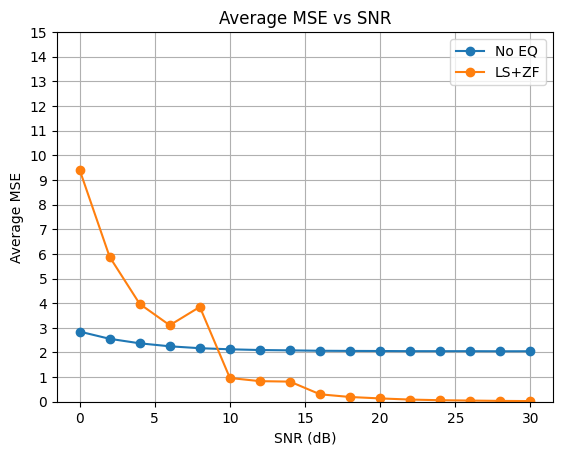

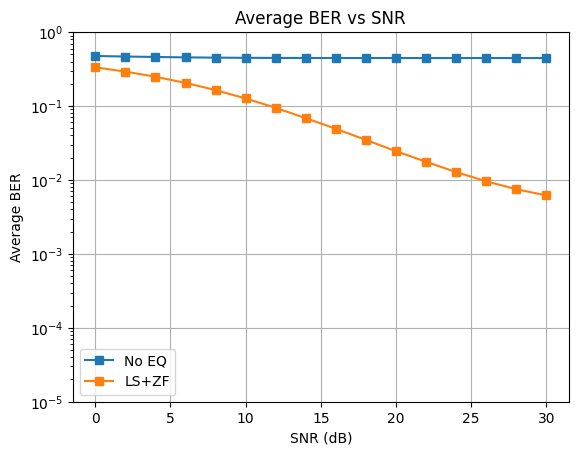

In [40]:
# %% [markdown]
# # 5G PUSCH Resource Grid - LS+ZF Equalization
# 
# This notebook compares the performance of two methods: 
# 1. Without equalization (No EQ)
# 2. With LS channel estimation and ZF equalization (LS+ZF)

# %%
import numpy as np
import matplotlib.pyplot as plt
# from compute_mse import compute_mse
# from ofdm_demodulate import ofdm_demodulate
# from qam16_gray import qam16_gray
# from compute_ber import compute_ber
# from qam16_gray_demod import qam16_gray_demod
# from ls_est_sparse import ls_est_sparse
# from TDLB100 import TDLB100
# from ofdm_modulate import ofdm_modulate
# from build_grid import build_grid
# from load_dmrs import load_dmrs
# from zf_eq import zf_eq

# %% [markdown]
# ## Parameters Setup

# %%
np.random.seed(42)
N_SC = 3276
N_SYM = 13
DMRS_COL = 3  # 0-indexed (originally 4 in MATLAB which is 1-indexed, so subtract 1)
fs = 61.44e6

# Load DMRS
dmrs_vec = load_dmrs('l1_mini_project_ce_eq_dmrs_data.xlsx', N_SC)

# %% [markdown]
# ## Generate Resource Grid

# %%
bits = np.random.randint(0, 2, (N_SC, N_SYM, 4), dtype=np.uint8)
symbols = qam16_gray(bits)
grid = build_grid(symbols, dmrs_vec, DMRS_COL)

print('=== 5G PUSCH Resource Grid Implementation ===')
print(f'Grid Size: {N_SC} subcarriers × {N_SYM+1} symbols')

data_cols = [i for i in range(N_SYM+1) if i != DMRS_COL]
num_data_columns = len(data_cols)

print(f'Data Columns: {num_data_columns} (excluding DMRS column {DMRS_COL})')
print(f'Total Bits: {N_SC * N_SYM * 4}')
print(f'Total Data Symbols: {N_SC * N_SYM}')
print('Modulation: 16QAM (4 bits per symbol)')

print('Verification Results:')
print(f'- Grid dimensions: {grid.shape}')
print(f'- Data columns filled: {num_data_columns}/{N_SYM+1}')

# %% [markdown]
# ## OFDM Modulation and Channel

# %%
tx_slot = ofdm_modulate(grid)
print(f'OFDM output length: {len(tx_slot)} samples')

# Apply channel
ch = TDLB100(fs, 25.0, seed=123)
y = ch.apply_channel(tx_slot)
n = ch.get_noise(y, 0)  # SNR=0 dB for initial test

rx = y + n
grid_est = ofdm_demodulate(rx)

# Remove DMRS column for data
data_grid = np.delete(grid_est, DMRS_COL, axis=1)
bits_rx = qam16_gray_demod(data_grid)

# %% [markdown]
# ## BER and MSE without equalization

# %%
ber = compute_ber(bits, bits_rx)
print(f'BER = {ber*100:.2f}%')

mse = compute_mse(symbols, data_grid)
print(f'MSE = {mse:.6e}')

# %% [markdown]
# ## Simulation for different SNRs and methods

# %%
snr_vals = np.arange(0, 31, 2)
n_runs = 14
methods = ['none', 'linear']  # 'none': no equalization, 'linear': LS+ZF
labels = ['No EQ', 'LS+ZF']

mse_avg = np.zeros((len(methods), len(snr_vals)))
ber_avg = np.zeros((len(methods), len(snr_vals)))

for run in range(n_runs):
    print(f'Run {run+1}/{n_runs}')
    for i, snr in enumerate(snr_vals):
        # Generate new random bits and symbols
        bits_tx = np.random.randint(0, 2, (N_SC, N_SYM, 4), dtype=np.uint8)
        symbols_tx = qam16_gray(bits_tx)
        grid_tx = build_grid(symbols_tx, dmrs_vec, DMRS_COL)
        tx_slot = ofdm_modulate(grid_tx)

        # Channel and noise
        ch = TDLB100(fs, 25.0, seed=42+run)
        y = ch.apply_channel(tx_slot)
        noise = ch.get_noise(y, snr)
        rx_slot = y + noise
        grid_rx = ofdm_demodulate(rx_slot)

        # For each method
        for m, method in enumerate(methods):
            if method == 'none':
                data_proc = np.delete(grid_rx, DMRS_COL, axis=1)
            else:
                H_est, _ = ls_est_sparse(grid_rx, dmrs_vec, DMRS_COL, method)
                data_proc = zf_eq(grid_rx, H_est, DMRS_COL)

            mse_avg[m, i] += compute_mse(symbols_tx, data_proc)
            bits_rx = qam16_gray_demod(data_proc)
            ber_avg[m, i] += compute_ber(bits_tx, bits_rx)

# Average over runs
mse_avg /= n_runs
ber_avg /= n_runs

# %% [markdown]
# ## Display Results

# %%
print('SNR (dB) |   MSE (No EQ)   |   MSE (LS+ZF)   |  BER (No EQ)  |  BER (LS+ZF)')
print('-----------------------------------------------------------------------------')
for i, snr in enumerate(snr_vals):
    print(f'{snr:8d} | {mse_avg[0, i]:14.6e} | {mse_avg[1, i]:14.6e} | {ber_avg[0, i]:12.4e} | {ber_avg[1, i]:12.4e}')

# %% [markdown]
# ## Plot Results

# %%
plt.figure()
for m in range(len(methods)):
    plt.plot(snr_vals, mse_avg[m], 'o-', markersize=6, linewidth=1.5, label=labels[m])
plt.xlabel('SNR (dB)')
plt.ylabel('Average MSE')
plt.title('Average MSE vs SNR')
plt.ylim(0, 15)
plt.yticks(np.arange(0, 16, 1))
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
for m in range(len(methods)):
    plt.semilogy(snr_vals, ber_avg[m], 's-', markersize=6, linewidth=1.5, label=labels[m])
plt.xlabel('SNR (dB)')
plt.ylabel('Average BER')
plt.title('Average BER vs SNR')
plt.ylim(1e-5, 1)
plt.legend()
plt.grid(True)
plt.show()

=== 5G PUSCH Resource Grid Implementation ===
Grid Size: 3276 subcarriers × 14 symbols
Data Columns: 13 (excluding DMRS column 3)
Total Bits: 170352
Total Data Symbols: 42588
Modulation: 16QAM (4 bits per symbol)
Verification Results:
- Grid dimensions: (3276, 14)
- Data columns filled: 13/14
OFDM output length: 61440 samples
BER = 52.77%
MSE = 3.727718e+00
Run 1/14
Run 2/14
Run 3/14
Run 4/14
Run 5/14
Run 6/14
Run 7/14
Run 8/14
Run 9/14
Run 10/14
Run 11/14
Run 12/14
Run 13/14
Run 14/14
SNR (dB) |   MSE (LS+ZF)   |   MSE (MMSE)   |  BER (LS+ZF)  |  BER (MMSE)
-----------------------------------------------------------------------------
       0 |   9.419759e+00 |   5.535169e-01 |   3.3407e-01 |   3.0981e-01
       2 |   5.879260e+00 |   4.639563e-01 |   2.9224e-01 |   2.6949e-01
       4 |   3.969840e+00 |   3.785479e-01 |   2.4903e-01 |   2.2728e-01
       6 |   3.103127e+00 |   3.029664e-01 |   2.0571e-01 |   1.8557e-01
       8 |   3.848231e+00 |   2.372799e-01 |   1.6440e-01 |   1.4

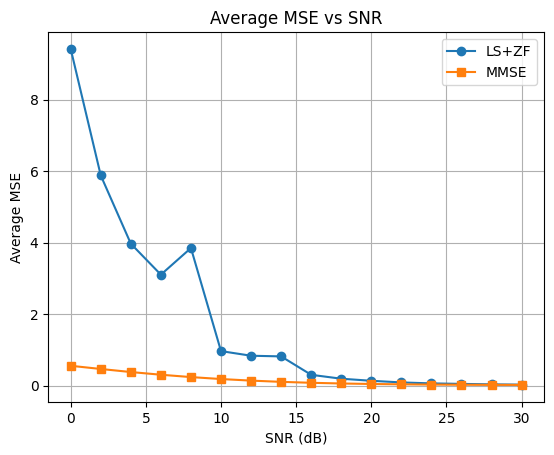

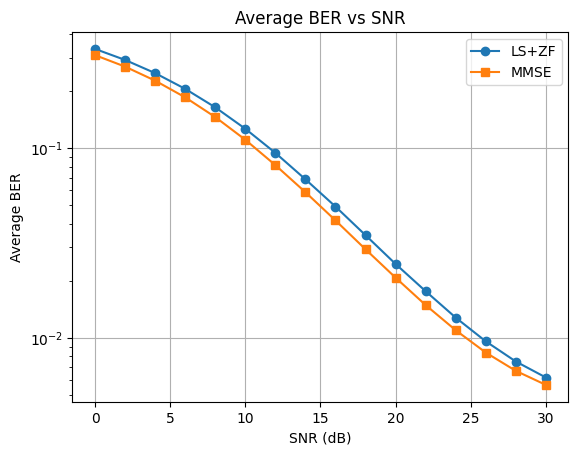

In [41]:
# %% [markdown]
# # 5G PUSCH Resource Grid - MMSE vs LS+ZF
# 
# This notebook compares the performance of two methods: 
# 1. LS channel estimation with ZF equalization (LS+ZF)
# 2. MMSE channel estimation with MMSE equalization (MMSE)

# %%
import numpy as np
import matplotlib.pyplot as plt
# from compute_mse import compute_mse
# from ofdm_demodulate import ofdm_demodulate
# from qam16_gray import qam16_gray
# from compute_ber import compute_ber
# from qam16_gray_demod import qam16_gray_demod
# from ls_est_sparse import ls_est_sparse
# from TDLB100 import TDLB100
# from ofdm_modulate import ofdm_modulate
# from build_grid import build_grid
# from load_dmrs import load_dmrs
# from zf_eq import zf_eq
# from mmse_est_sparse import mmse_est_sparse
# from mmse_eq import mmse_eq

# %% [markdown]
# ## Parameters Setup

# %%
np.random.seed(42)
N_SC = 3276
N_SYM = 13
DMRS_COL = 3  # 0-indexed (originally 4 in MATLAB which is 1-indexed, so subtract 1)
fs = 61.44e6
delta_f = 15e3      # subcarrier spacing (Hz)
tau_rms = 100e-9    # RMS delay spread (s)

# Load DMRS
dmrs_vec = load_dmrs('l1_mini_project_ce_eq_dmrs_data.xlsx', N_SC)

# %% [markdown]
# ## Generate Resource Grid

# %%
bits = np.random.randint(0, 2, (N_SC, N_SYM, 4), dtype=np.uint8)
symbols = qam16_gray(bits)
grid = build_grid(symbols, dmrs_vec, DMRS_COL)

print('=== 5G PUSCH Resource Grid Implementation ===')
print(f'Grid Size: {N_SC} subcarriers × {N_SYM+1} symbols')

data_cols = [i for i in range(N_SYM+1) if i != DMRS_COL]
num_data_columns = len(data_cols)

print(f'Data Columns: {num_data_columns} (excluding DMRS column {DMRS_COL})')
print(f'Total Bits: {N_SC * N_SYM * 4}')
print(f'Total Data Symbols: {N_SC * N_SYM}')
print('Modulation: 16QAM (4 bits per symbol)')

print('Verification Results:')
print(f'- Grid dimensions: {grid.shape}')
print(f'- Data columns filled: {num_data_columns}/{N_SYM+1}')

# %% [markdown]
# ## OFDM Modulation and Channel

# %%
tx_slot = ofdm_modulate(grid)
print(f'OFDM output length: {len(tx_slot)} samples')

# Apply channel
ch = TDLB100(fs, 25.0, seed=123)
y = ch.apply_channel(tx_slot)
n = ch.get_noise(y, 0)  # SNR=0 dB for initial test

rx = y + n
grid_est = ofdm_demodulate(rx)

# Remove DMRS column for data
data_grid = np.delete(grid_est, DMRS_COL, axis=1)
bits_rx = qam16_gray_demod(data_grid)

# %% [markdown]
# ## BER and MSE without equalization (for reference)

# %%
ber = compute_ber(bits, bits_rx)
print(f'BER = {ber*100:.2f}%')

mse = compute_mse(symbols, data_grid)
print(f'MSE = {mse:.6e}')

# %% [markdown]
# ## Simulation for different SNRs and methods

# %%
snr_vals = np.arange(0, 31, 2)
n_runs = 14

mse_zf = np.zeros(len(snr_vals))
ber_zf = np.zeros(len(snr_vals))
mse_mmse = np.zeros(len(snr_vals))
ber_mmse = np.zeros(len(snr_vals))

for run in range(n_runs):
    print(f'Run {run+1}/{n_runs}')
    for i, snr in enumerate(snr_vals):
        # Generate new random bits and symbols
        bits_tx = np.random.randint(0, 2, (N_SC, N_SYM, 4), dtype=np.uint8)
        symbols_tx = qam16_gray(bits_tx)
        grid_tx = build_grid(symbols_tx, dmrs_vec, DMRS_COL)
        tx_slot = ofdm_modulate(grid_tx)

        # Channel and noise
        ch = TDLB100(fs, 25.0, seed=42+run)
        y = ch.apply_channel(tx_slot)
        noise = ch.get_noise(y, snr)
        rx_slot = y + noise
        grid_rx = ofdm_demodulate(rx_slot)

        # --- LS (linear) estimation and ZF equalization ---
        H_est_ls, _ = ls_est_sparse(grid_rx, dmrs_vec, DMRS_COL, 'linear')
        data_zf = zf_eq(grid_rx, H_est_ls, DMRS_COL)
        mse_zf[i] += compute_mse(symbols_tx, data_zf)
        bits_zf = qam16_gray_demod(data_zf)
        ber_zf[i] += compute_ber(bits_tx, bits_zf)

        # --- MMSE estimation and MMSE equalization ---
        H_est_mmse, noise_var = mmse_est_sparse(grid_rx, dmrs_vec, DMRS_COL, delta_f, tau_rms)
        data_mmse = mmse_eq(grid_rx, H_est_mmse, noise_var, DMRS_COL)
        mse_mmse[i] += compute_mse(symbols_tx, data_mmse)
        bits_mmse = qam16_gray_demod(data_mmse)
        ber_mmse[i] += compute_ber(bits_tx, bits_mmse)

# Average over runs
mse_zf /= n_runs
ber_zf /= n_runs
mse_mmse /= n_runs
ber_mmse /= n_runs

# %% [markdown]
# ## Display Results

# %%
print('SNR (dB) |   MSE (LS+ZF)   |   MSE (MMSE)   |  BER (LS+ZF)  |  BER (MMSE)')
print('-----------------------------------------------------------------------------')
for i, snr in enumerate(snr_vals):
    print(f'{snr:8d} | {mse_zf[i]:14.6e} | {mse_mmse[i]:14.6e} | {ber_zf[i]:12.4e} | {ber_mmse[i]:12.4e}')

# %% [markdown]
# ## Plot Results

# %%
plt.figure()
plt.plot(snr_vals, mse_zf, 'o-', markersize=6, linewidth=1.5, label='LS+ZF')
plt.plot(snr_vals, mse_mmse, 's-', markersize=6, linewidth=1.5, label='MMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Average MSE')
plt.title('Average MSE vs SNR')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.semilogy(snr_vals, ber_zf, 'o-', markersize=6, linewidth=1.5, label='LS+ZF')
plt.semilogy(snr_vals, ber_mmse, 's-', markersize=6, linewidth=1.5, label='MMSE')
plt.xlabel('SNR (dB)')
plt.ylabel('Average BER')
plt.title('Average BER vs SNR')
plt.legend()
plt.grid(True)
plt.show()